## Задание 4

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [2]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

Загрузка датасета COCO и COCO API

In [3]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2022-07-31 03:01:04--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.143.188
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.143.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  15.5MB/s    in 20m 32s 

2022-07-31 03:21:37 (15.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-07-31 03:21:37--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.40.140
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.40.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  15.7MB/s    in 75s     

2022-07-31 03:22:53 (10.4 MB/s) - 

Подготовка COCO API

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

Универсальный класс Dataset для сегментации

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        # dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)


    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=20.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


Уменьшаем датасет

In [8]:
COCO_dataset_train.cat_ids=COCO_dataset_train.cat_ids[:200]
COCO_dataset_train.img_list=COCO_dataset_train.img_list[:200]

COCO_dataset_val.cat_ids=COCO_dataset_val.cat_ids[:50]
COCO_dataset_val.img_list=COCO_dataset_val.img_list[:50]

In [9]:
NUM_EPOCHS = 4
BATCH_SIZE = 8
inp_size = 256

In [10]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,inp_size=inp_size)

val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=inp_size)

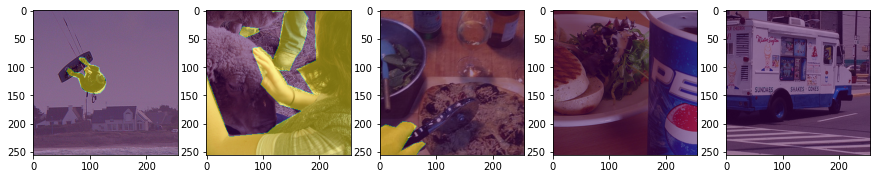

In [11]:
img, mask = next(iter(val_ds.take(1)))

fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask[...,0][i],alpha=0.5)
plt.show()

Создаем нейросеть

In [12]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)
args = {'padding':'same', 'activation': 'relu','kernel_regularizer':wd}

In [13]:
def build_model():
    x = tf.keras.layers.Input((inp_size, inp_size, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), **args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), **args)(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3),**args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [14]:
checkpoint_dir = './checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [15]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [16]:
hist = model.fit(
                 train_ds, 
                 batch_size=BATCH_SIZE,
                 epochs=NUM_EPOCHS,
                 validation_data=val_ds,
                 callbacks=[checkpoint_callback]
               )

Epoch 1/4
25/25 [==============================] - 1422s 57s/step - loss: 2.7716 - accuracy: 0.7635 - val_loss: 0.9366 - val_accuracy: 0.7763
Epoch 2/4
25/25 [==============================] - 1414s 57s/step - loss: 0.7369 - accuracy: 0.7742 - val_loss: 0.6349 - val_accuracy: 0.7763
Epoch 3/4
25/25 [==============================] - 1414s 57s/step - loss: 0.6186 - accuracy: 0.7497 - val_loss: 0.5819 - val_accuracy: 0.7763
Epoch 4/4
25/25 [==============================] - 1424s 57s/step - loss: 0.5892 - accuracy: 0.7595 - val_loss: 0.5596 - val_accuracy: 0.7763


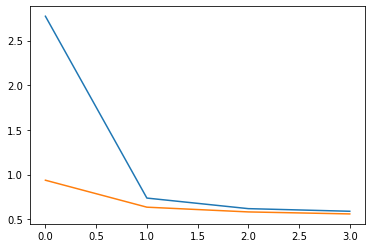

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

## Проверяем модель

In [18]:
img, mask = next(iter(val_ds.take(1)))
masks_pred = model.predict(img)

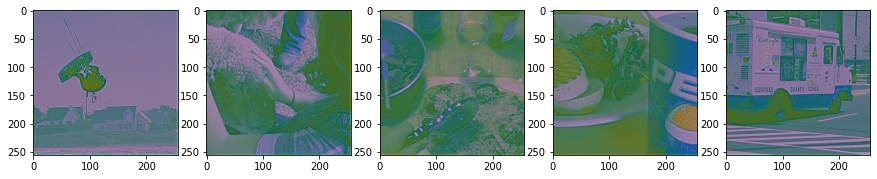

In [19]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(masks_pred[...,0][i],alpha=0.5)
plt.show()

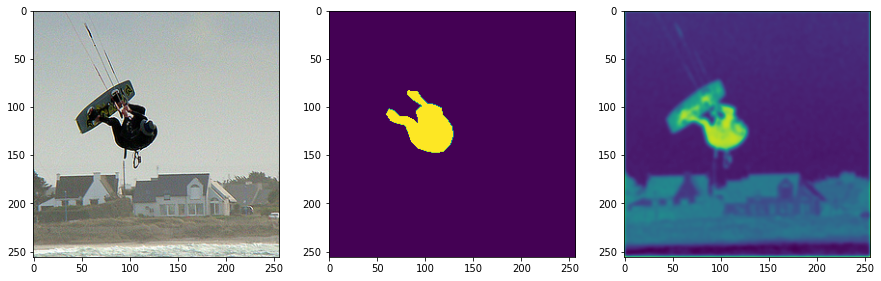

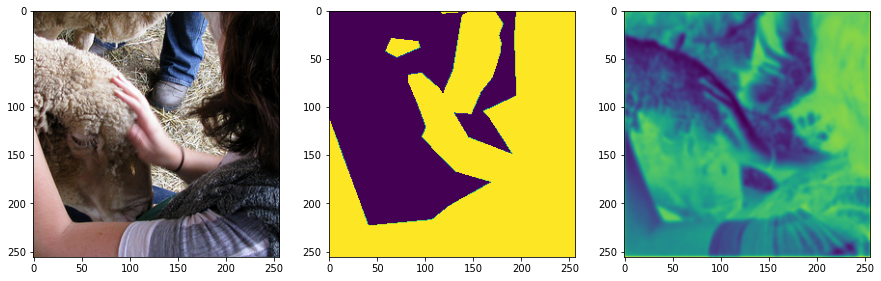

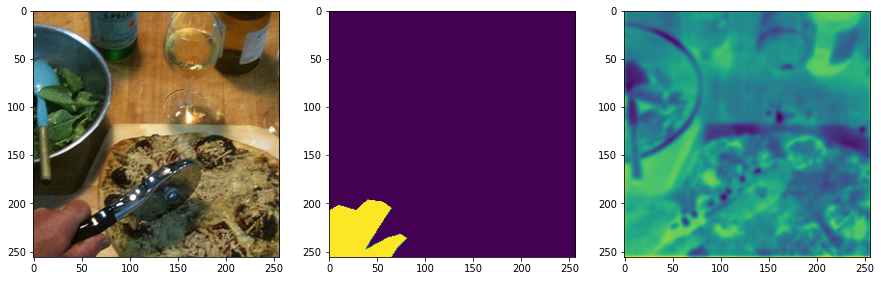

In [29]:
for i in range(3):
    fig, ax  = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(img[i])
    ax[1].imshow(np.squeeze(mask[i]))
    ax[2].imshow(np.squeeze(masks_pred[i]))
    plt.show()